In [1]:
from utils.classifier import *
from utils.dataloader import *
from utils.features import *
from utils.helper import *
from utils.processing import *
import pickle

In [2]:
RANDOM_STATE = 66
ROOT_PATH, DATA_PATH, OUT_PATH = get_paths()
PARAMS = []
L= 17
print(ROOT_PATH)

/Users/moooooo16/Documents/Computer Vision/Project/elpv


In [3]:
from sklearn.model_selection import train_test_split
img_path, prob, types, labels= load_data(DATA_PATH)

feature_builder = FeatureExtraction(DATA_PATH, img_path, labels, L)
X_train, X_test, y_train, y_test = feature_builder.split_data(train_test_split, randome_state=RANDOM_STATE, stratify=True, split_ratio=0.25)
# X_train, X_val, y_train, y_val = feature_builder.split_data(train_test_split, randome_state=RANDOM_STATE, stratify=True, split_ratio=0.1)
print(X_train.shape, X_test.shape)

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]
(1968, 300, 300) (656, 300, 300)


In [4]:
preprocess_pipeline = [
    # (strech_img, {
    #     }),
    # (clach_img, {
    #     'clipLimit': 2.0,
    #     'tileGridSize': (8, 8)}),
    # (guassian_blur, {
    #     'kernel_size': (0, 0),
    #     'sigmaX': 3}),
    # (lap_feature, {
    #     'dst': -1,
    #     'ksize' : 5}),
    # (morpo_opening, {
    #     'kernel': np.ones((2,2), np.uint8),
    #     'iterations': 1}),
    (morph_smoothing, {
        'ses' : feature_builder.ses})
]

In [5]:
X_train_prepro = feature_builder.preprocess(X_train, preprocess_pipeline = preprocess_pipeline)
X_test_prepro = feature_builder.preprocess(X_test, preprocess_pipeline = preprocess_pipeline)

with open(os.path.join(OUT_PATH ,'X_morph_smoothing.pkl'), 'wb') as f:
    pickle.dump((X_train_prepro, X_test_prepro), f)

Pre-processing images: 100%|██████████| 656/656 [06:46<00:00,  1.61it/s]


In [6]:
X_train_prepro,  X_test_prepro = None, None

with open(os.path.join(OUT_PATH ,'X_morph_smoothing.pkl'), 'rb') as f:
    X_train_prepro, X_test_prepro = pickle.load(f)

In [7]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# indices = np.where( (y_train == 0) | (y_train == 4))[0]
mono_indices = np.where(y_train == 0)[0]
poly_indices = np.where(y_train == 4)[0]
combined_indices = np.where((y_train == 0) | (y_train == 4))[0]

mono_thresh_mean, mono_thresh_std = feature_builder.calculate_threshold(kf, X_train_prepro, y_train, mono_indices )
poly_thresh_mean, poly_thresh_std = feature_builder.calculate_threshold(kf, X_train_prepro, y_train, poly_indices )
combin_thresh_mean, combin_thresh_std = feature_builder.calculate_threshold(kf, X_train_prepro, y_train, combined_indices )

with open(os.path.join(OUT_PATH ,'thresholding.pkl'), 'wb') as f:
    pickle.dump((mono_thresh_mean, mono_thresh_std, poly_thresh_mean, poly_thresh_std, combin_thresh_mean, combin_thresh_std), f)

print(f'Mono threshold: {mono_thresh_mean}, {mono_thresh_std}')
print(f'Poly threshold: {poly_thresh_mean}, {poly_thresh_std}')
print(f'Combined threshold: {combin_thresh_mean}, {combin_thresh_std}')
# X shape: (904, 90000), y shape: (227, 90000)
# X_plus shape: (90000, 904)
# y_hat shape: (227, 90000)
# C shape: (227,)
# C shape after reshape: (227, 1)
# errors shape: (227,)

Fold 1 mean error: 859.1335704471556, std error: 306.9898130876804
Fold 2 mean error: 839.1569651153563, std error: 299.6505291797389
Fold 3 mean error: 794.9727964955072, std error: 277.27141368267377
Fold 4 mean error: 887.4438913951182, std error: 311.16467003796953
Fold 5 mean error: 944.4028607505694, std error: 381.5654621692531
Fold 1 mean error: 1522.685429855814, std error: 635.0793658893118
Fold 2 mean error: 1662.5858630763883, std error: 665.0561742850533
Fold 3 mean error: 1542.85790218974, std error: 659.1537245027969
Fold 4 mean error: 1669.7340936984488, std error: 684.4801519597615
Fold 5 mean error: 1600.2363666738909, std error: 636.9188951336752
Fold 1 mean error: 1175.280969598148, std error: 587.715821665349
Fold 2 mean error: 1257.0014615966372, std error: 637.9261603157959
Fold 3 mean error: 1209.803416484103, std error: 584.177998163461
Fold 4 mean error: 1245.6201172109602, std error: 660.9216723086034
Fold 5 mean error: 1231.8951646224627, std error: 594.1256

In [8]:
with open(os.path.join(OUT_PATH ,'thresholding.pkl'), 'rb') as f:
    mono_thresh_mean, mono_thresh_std, poly_thresh_mean, poly_thresh_std,combin_thresh_mean, combin_thresh_std = pickle.load(f)

In [9]:
X_train_mono, X_train_poly, y_train_mono, y_train_poly = mono_poly_split(X_train_prepro, y_train)
X_test_mono, X_test_poly, y_test_mono, y_test_poly = mono_poly_split(X_test_prepro, y_test)
combine_train_X, combine_train_y = combine_mono_poly(X_train_mono, X_train_poly, y_train_mono, y_train_poly)
combine_test_X, combine_test_y = combine_mono_poly(X_test_mono, X_test_poly, y_test_mono, y_test_poly)

In [10]:
mono_errors = feature_builder.calculate_error(X_train_mono,  X_test_mono)
poly_errors = feature_builder.calculate_error(X_train_poly,  X_test_poly)
combine_error = feature_builder.calculate_error(combine_train_X,  combine_test_X)

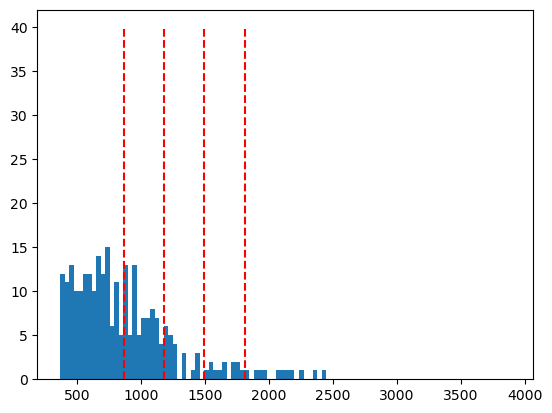

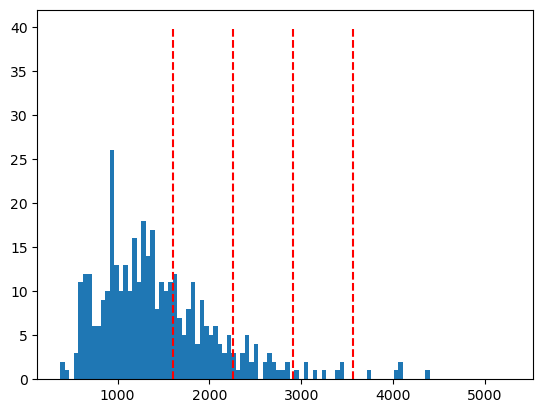

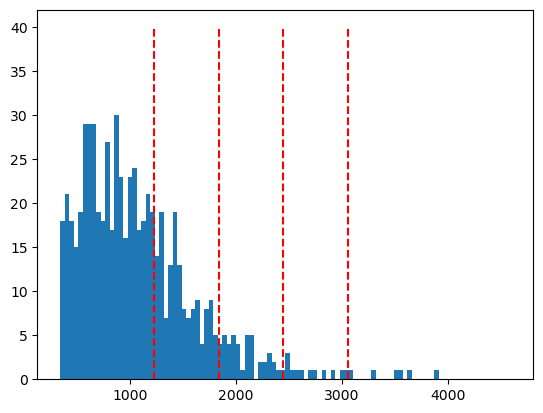

In [11]:
plot_reconstruct(mono_errors, mono_thresh_mean, mono_thresh_std)
plot_reconstruct(poly_errors, poly_thresh_mean, poly_thresh_std)
plot_reconstruct(combine_error, combin_thresh_mean, combin_thresh_std)

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       147
           1       0.05      0.03      0.04        29
           2       0.00      0.00      0.00        14
           3       0.92      0.14      0.24        78

    accuracy                           0.56       268
   macro avg       0.40      0.28      0.26       268
weighted avg       0.61      0.56      0.49       268




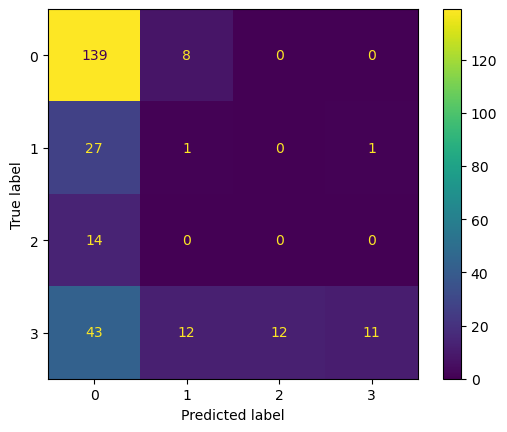

(0.5634328358208955, 0.25894894894894893)

In [12]:
mono_pred = reconstruct_pred(mono_errors, mono_thresh_mean, mono_thresh_std, y_test_mono.shape[0])
get_report(y_test_mono, mono_pred)

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.92      0.74       230
           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        13
           3       1.00      0.06      0.11       100

    accuracy                           0.56       388
   macro avg       0.40      0.25      0.21       388
weighted avg       0.62      0.56      0.47       388




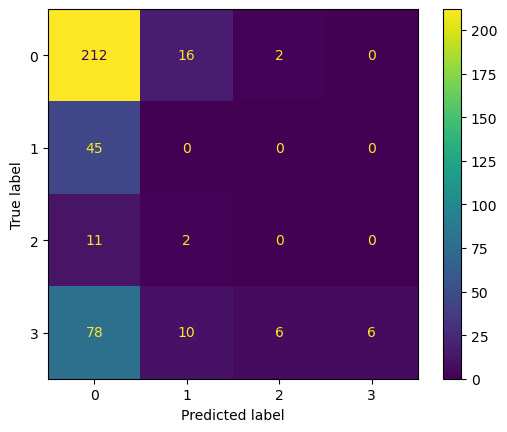

(0.5618556701030928, 0.21232966457023061)

In [13]:
poly_pred = reconstruct_pred(poly_errors, poly_thresh_mean, poly_thresh_std, y_test_poly.shape[0])
get_report(y_test_poly, poly_pred)

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.92      0.71       377
           1       0.07      0.04      0.05        74
           2       0.00      0.00      0.00        27
           3       1.00      0.04      0.08       178

    accuracy                           0.54       656
   macro avg       0.41      0.25      0.21       656
weighted avg       0.61      0.54      0.44       656




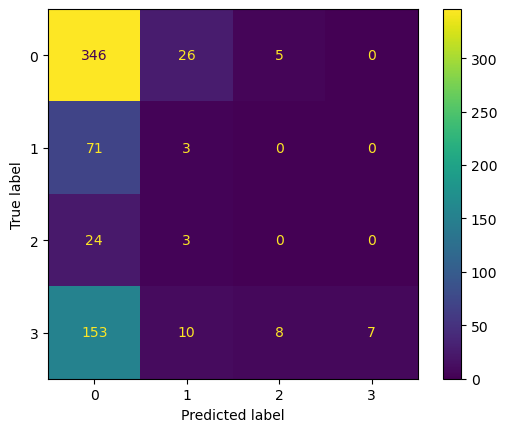

(0.5426829268292683, 0.2100167917126971)

In [14]:
combine_pred = reconstruct_pred(combine_error, combin_thresh_mean, combin_thresh_std, combine_test_y.shape[0])
get_report(combine_test_y, combine_pred)